In [15]:
import time


def compare_runtime(
    configuration: dict, algorithms: list[tuple[str, any]], verbose=False
):
    results = {}
    for alg_name, alg in algorithms:
        start_time = time.process_time()
        alg(**configuration)
        end_time = time.process_time()
        results[alg_name] = end_time - start_time
        if verbose:
            print(f"Finished with {alg_name}")
    return results

In [35]:
import causalpathalgorithms

datasets = ["data/college-msg.csv", "data/reality-mining.csv"]
algorithms = [
    ("PaCo", causalpathalgorithms.PaCo),
    ("PaCo2", causalpathalgorithms.PaCo2),
    ("PathPy", causalpathalgorithms.pathpy_causal_paths),
    ("PathPy2", causalpathalgorithms.pathpy2_causal_paths),
]

In [17]:
import utils

(_, college_msg_edge_set) = utils.read_time_stamped_csv(
    "data/college-msg.csv", "datetime"
)

In [18]:
import pandas as pd

pd.set_option("display.width", 2000)

In [19]:
import datetime
import pandas as pd


def exp_runtime(dataset_sorted_edges, verbose=False):
    edge_list_size_step = int(len(dataset_sorted_edges) / 5)
    # dictionary containing parameter keys and the values that we want to test. Each value is a tuple containing
    # the readable format and the real parameter
    alg_parameter_ranges = {
        "max_path_length": range(1, 7),
        "sorted_edges": range(
            edge_list_size_step,
            len(dataset_sorted_edges) + 1,
            edge_list_size_step,
        ),
        "delta_time": range(10, 51, 10),
    }
    alg_parameter_defaults = {
        "sorted_edges": len(dataset_sorted_edges),
        "delta_time": 30,
        "max_path_length": 4,
    }
    parameter_preprocessors = {
        "sorted_edges": lambda n: dataset_sorted_edges[:n],
        # "delta_time": lambda m: datetime.timedelta(minutes=m),
        "delta_time": lambda m: m * 60,
    }

    results = []

    for param_key in alg_parameter_ranges.keys():
        if verbose:
            print(f"testing {param_key}")
        for param_value in alg_parameter_ranges[param_key]:
            # Merge defaults with current iteration
            readable_params = alg_parameter_defaults | {param_key: param_value}

            # Apply processing to readable parameters to create proper parameters like an edge set or timedelta object
            processed_params = readable_params.copy()
            for processor_key, processor in parameter_preprocessors.items():
                processed_params[processor_key] = processor(
                    readable_params[processor_key]
                )

            runtimes_dict = compare_runtime(processed_params, algorithms, verbose)
            current_result = runtimes_dict | {"experiment": param_key} | readable_params
            results.append(current_result)
            pd.DataFrame(results).to_csv("results_pathpy2.csv", index=False)

    return results

In [42]:
from matplotlib import pyplot as plt


def plot_K(df, algorithms):
    n_df = df[df["experiment"] == "max_path_length"]
    plt.figure(figsize=(2 ^ 4, (3 * (2 ^ 4)) / 4))
    for algorithm in algorithms:
        plt.plot(n_df["max_path_length"], n_df[algorithm] / 60, label=algorithm)
    plt.xlabel("K")
    plt.xticks(n_df["max_path_length"])
    plt.ylabel("run-time [h]")
    plt.legend(loc="upper right")
    plt.title(
        "Run-time of three causal path finding algorithms for varying max path lengths"
    )

    plt.tight_layout()
    plt.show()


def plot_N(df, algorithms):
    n_df = df[df["experiment"] == "sorted_edges"]
    plt.figure(figsize=(2 ^ 4, (3 * (2 ^ 4)) / 4))
    for algorithm in algorithms:
        plt.plot(n_df["sorted_edges"], n_df[algorithm] / 60, label=algorithm)
    plt.xlabel("N")
    plt.ylabel("run-time [h]")
    plt.legend(loc="upper right")
    plt.title(
        "Run-time of three causal path finding algorithms for varying network size"
    )

    plt.tight_layout()
    plt.show()


def plot_dt(df, algorithms):
    n_df = df[df["experiment"] == "delta_time"]
    plt.figure(figsize=(2 ^ 4, (3 * (2 ^ 4)) / 4))
    for algorithm in algorithms:
        plt.plot(n_df["delta_time"], n_df[algorithm] / 60, label=algorithm)
    plt.xlabel("delta_time [min]")
    plt.ylabel("run-time [h]")
    plt.legend(loc="upper right")
    plt.title("Run-time of three causal path finding algorithms for varying delta time")

    plt.tight_layout()
    plt.show()


def plot_all(df):
    plottable_algorithms = [algorithm for algorithm, _ in algorithms if algorithm in df]
    plot_K(df, plottable_algorithms)
    plot_N(df, plottable_algorithms)
    plot_dt(df, plottable_algorithms)

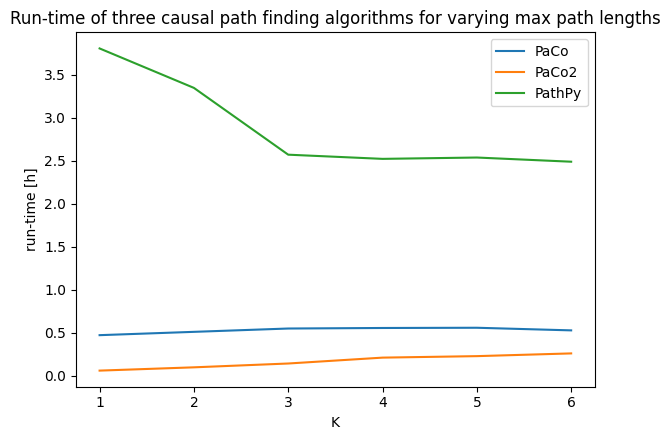

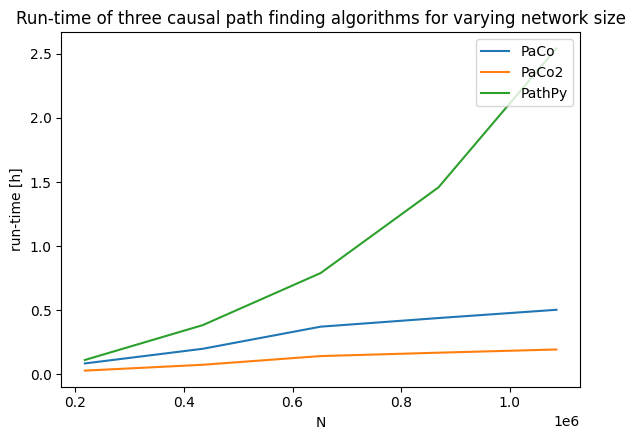

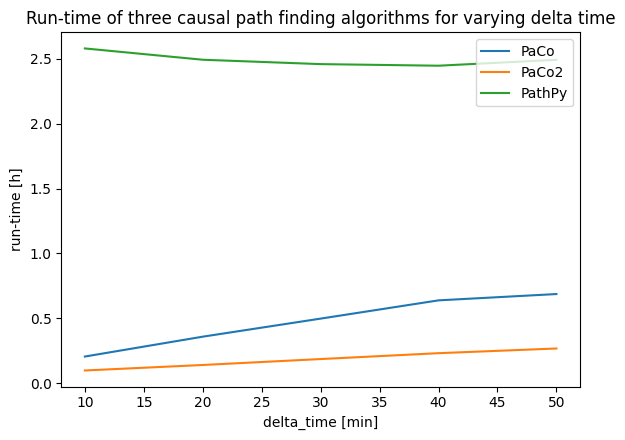

In [43]:
import os
import pandas as pd
from functools import reduce


def read_result_csvs():
    results = {}
    for dir in os.listdir("results"):
        if ".progress" not in dir:
            raw_filename = os.path.splitext(dir)[0]
            [algorithm_name, database_index] = raw_filename.split("_")
            exp_iteration_df = pd.read_csv(f"results/{raw_filename}.csv")
            df = results.get(database_index, exp_iteration_df)
            df[algorithm_name] = exp_iteration_df[algorithm_name]
            df["dataset"] = datasets[int(database_index)]
            results[database_index] = df
    return reduce(lambda a, b: a.concat(b), results.values())


results_df = read_result_csvs()
plot_all(results_df)